We'll try option \#3, with only loading the V photometry and setting a prior on the overall system temperature from the estimated spectral type.

In [1]:
import phoebe
import numpy as np

b = phoebe.default_binary()

times, fluxes, sigmas = np.loadtxt('../lc.V.data', unpack=True)
b.add_dataset('lc', 
              times=times, 
              fluxes=fluxes, 
              sigmas=sigmas, 
              compute_phases=phoebe.linspace(0,1,251),
              passband='Johnson:V', 
              dataset='lcV')

#times, fluxes, sigmas = np.loadtxt('../lc.B.data', unpack=True)
#b.add_dataset('lc', 
#              times=times, 
#              fluxes=fluxes, 
#              sigmas=sigmas, 
#              compute_phases=phoebe.linspace(0,1,251),
#              passband='Johnson:B', 
#              dataset='lcB')
#b.set_value('pblum_mode', dataset='lcB', value='dataset-coupled')


times1, rvs1, sigmas1 = np.loadtxt('../rv1.data', unpack=True)
times2, rvs2, sigmas2 = np.loadtxt('../rv2.data', unpack=True)
if not np.all(times1==times2):
    raise ValueError("unequal RV times")

b.add_dataset('rv', 
              times=times1, 
              rvs={'primary': rvs1, 'secondary': rvs2},
              sigmas={'primary': sigmas1, 'secondary': sigmas2},
              compute_phases=phoebe.linspace(0,1,101),
              dataset='rv01')
b.set_value_all('rv_method', 'dynamical')

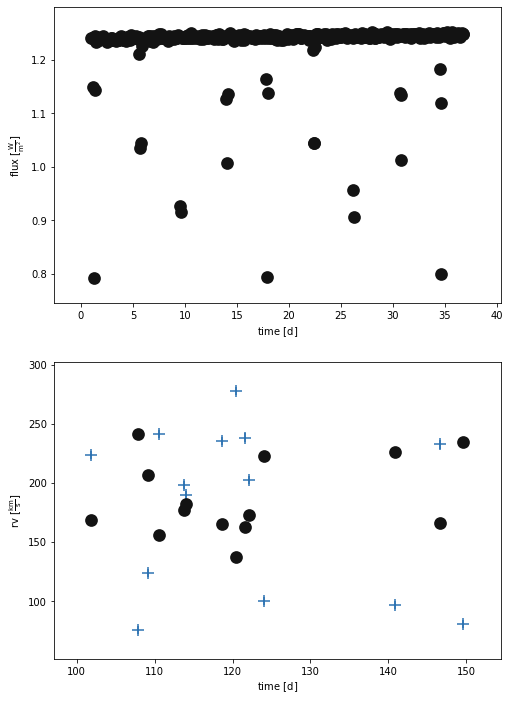

In [2]:
_ = b.plot(show=True)

Let's first get the period using the LC periodogram.

In [3]:
b.add_solver('estimator.lc_periodogram', solver='lcper_solv')

<ParameterSet: 13 parameters | qualifiers: algorithm, minimum_n_cycles, lc_datasets, objective, comments, lc_combine, samples_per_peak, nyquist_factor, use_server, duration, sample_periods, component, sample_mode>

In [4]:
b.run_solver(solver='lcper_solv', solution='lcper_sol')

<ParameterSet: 10 parameters | qualifiers: period_factor, adopt_values, adopt_parameters, comments, fitted_values, power, adopt_distributions, fitted_units, period, fitted_twigs>

In [5]:
b.adopt_solution('lcper_sol')

<ParameterSet: 16 parameters | contexts: dataset, component>

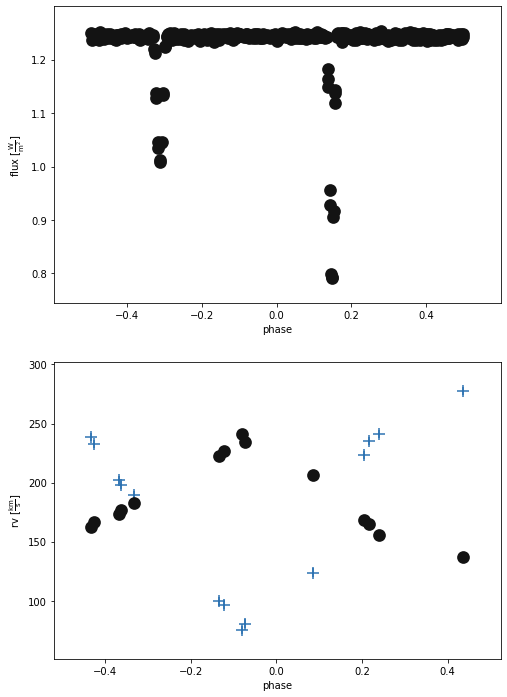

In [6]:
_ = b.plot(x='phases', show=True)

Now we'll run estimators on the RV and LC, respectively

In [7]:
b.add_solver('estimator.rv_geometry', solver='rvgeom_solv')

<ParameterSet: 7 parameters | qualifiers: phase_nbins, comments, rv_datasets, use_server, expose_model, orbit, phase_bin>

In [8]:
b.run_solver(solver='rvgeom_solv', solution='rvgeom_sol')

<ParameterSet: 17 parameters | components: secondary, primary>

In [9]:
b.flip_constraint('asini@binary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {asini@binary@component} / (sin({incl@binary@component})) (solar units) => 5.3 solRad>

In [10]:
b.adopt_solution('rvgeom_sol')

<ParameterSet: 24 parameters | contexts: system, dataset, component>

In [11]:
b.add_solver('estimator.lc_geometry', solver='lcgeom_solv')

<ParameterSet: 9 parameters | qualifiers: lc_datasets, phase_nbins, comments, lc_combine, use_server, t0_near_times, expose_model, orbit, phase_bin>

In [12]:
b.run_solver(solver='lcgeom_solv', solution='lcgeom_sol')

/home/kyle/.local/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10382: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._value = np.array(value)


<ParameterSet: 21 parameters | qualifiers: primary_width, adopt_values, secondary_depth, analytic_phases, secondary_width, input_sigmas, analytic_fluxes, comments, fitted_units, input_fluxes, orbit, fitted_twigs, primary_phase, input_phases, adopt_parameters, secondary_phase, eclipse_edges, fitted_values, adopt_distributions, primary_depth, analytic_best_model>

In [13]:
b.adopt_solution('lcgeom_sol')

<ParameterSet: 12 parameters | contexts: dataset, component>

And now let's determine which effects are safe to turn off **at this point** (we'll need to keep revisiting these comparisons).

In [14]:
b.run_compute(model='compare_all')
b.run_compute(irrad_method='none', model='compare_irrad_off')
b.run_compute(distortion_method='sphere', model='compare_roche_off')

100%|██████████| 301/301 [00:06<00:00, 48.07it/s]


<ParameterSet: 7 parameters | kinds: rv, lc>

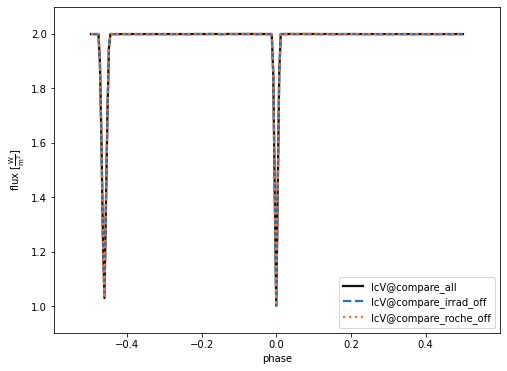

In [15]:
_ = b.plot(kind='lc', context='model', x='phases', legend=True, show=True)

(NOTE: in real life we would want to do a bit more quantitative checks here as shown in the tutorial, but I'm a cheater and know the answer, so moving on...)

In [16]:
b.set_value_all('distortion_method', 'sphere')
b.set_value_all('irrad_method', 'none')

And now do a very quick and dirty optimization for pblum before checking our residuals.  This shouldn't take many iterations, so we'll run it locally.

In [17]:
b.add_solver('optimizer.nelder_mead', fit_parameters=['pblum@primary@lcV'], solver='nm_solv')

<ParameterSet: 14 parameters | qualifiers: continue_from, maxiter, priors_combine, fit_parameters, xatol, priors, comments, progress_every_niters, use_server, compute, initial_values, fatol, expose_lnprobabilities, adaptive>

In [18]:
b.run_solver('nm_solv', maxiter=50, solution='nm_pblum_sol')

 38%|███▊      | 19/50 [01:39<02:41,  5.22s/it]


<ParameterSet: 11 parameters | qualifiers: success, adopt_values, adopt_parameters, niter, message, comments, fitted_values, adopt_distributions, fitted_units, initial_values, fitted_twigs>

Let's see where things stand in the forward model

In [19]:
b.adopt_solution('nm_pblum_sol')

<ParameterSet: 1 parameters>

In [20]:
b.run_compute()

100%|██████████| 301/301 [00:02<00:00, 136.04it/s]


<ParameterSet: 7 parameters | kinds: rv, lc>

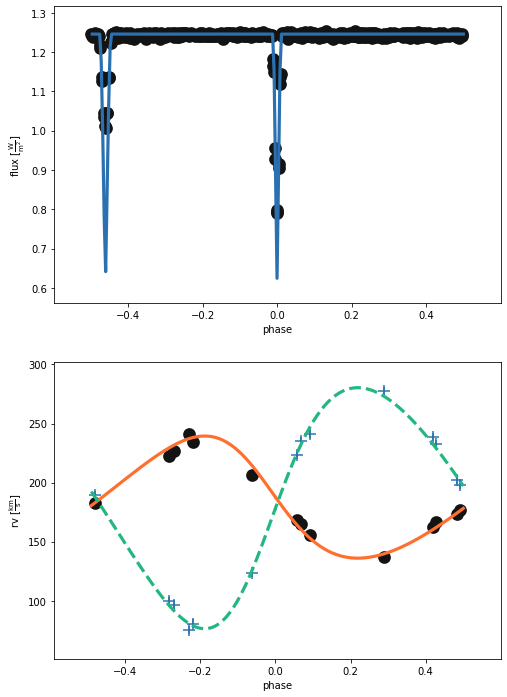

In [21]:
_ = b.plot(model='latest', x='phases', show=True)

Ok.... now on to dealing with the temperatures.  Let's try using the observed spectral type as a prior and initial starting point.  The problem is this applies to the system as a whole, so let's [create a custom constraint](http://phoebe-project.org/docs/2.4/tutorials/constraints_custom) for that.  We already know that distortion is minimal (since we're using spheres), so the Stefan-Boltzmann blackbody approximation used here is somewhat reasonable.... but it still is an approximation.

In [22]:
teffsys_def = phoebe.parameters.FloatParameter(qualifier='teff',
                                               default_unit=phoebe.u.K,
                                               value=6000, 
                                               description='luminosity-weighted effective temperature')

teffsys_param, created = b.get_or_create('teff', teffsys_def, context='component', component='binary')

T1 = b.get_parameter(qualifier='teff', component='primary')
R1 = b.get_parameter(qualifier='requiv', component='primary')
L1 = R1**2 * T1**4  # note: not really luminosity, but constants will cancel later
T2 = b.get_parameter(qualifier='teff', component='secondary')
R2 = b.get_parameter(qualifier='requiv', component='secondary')
L2 = R2**2 * T2**4

rhs = (T1 * L1 + T2 * L2) / (L1 + L2)

b.add_constraint(teffsys_param, rhs)

<ParameterSet: 1 parameters>

In [23]:
print(b.filter(qualifier='teff', context='component'))

ParameterSet: 3 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K
C           teff@binary@component: 6000.0 K


**NOTE**: custom constraints aren't (easily) flippable.... yet.  So instead of enforcing an exact value anyways, let's just apply a prior now that we'll use for both optimization and sampling.  We know that the primary component must be AT LEAST this value, so we'll set that to 6250 so we start near a reasonable system temperature.

In [26]:
b.set_value(qualifier='teff', component='primary', value=6250)

In [27]:
print(b.filter(qualifier='teff', context='component'))

ParameterSet: 3 parameters
           teff@primary@component: 6250.0 K
         teff@secondary@component: 6000.0 K
C           teff@binary@component: 6135.182883190914 K


We know that the system has an observed spectral type of F9, so let's put a gaussian prior around 6200 K.

In [28]:
b.add_distribution('teff@binary', phoebe.gaussian(6200, 50), distribution='teff_prior')

<ParameterSet: 1 parameters>

**TODO**: fix bug with plot_distribution_collection on a single distribution.

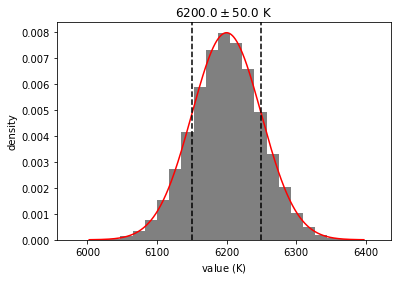

In [29]:
_ = b.get_parameter('teff_prior').plot(show=True)

In [30]:
b.set_value('priors', 'teff_prior')

And now we'll optimize for some of the most critical parameters that seem off.

In [31]:
b.add_server('remoteslurm', crimpl_name='terra', conda_env='phoebe', nprocs=48, server='terra')

<ParameterSet: 11 parameters | qualifiers: mail_type, walltime, conda_env, use_mpi, slurm_job_name, mail_user, crimpl_name, install_deps, nprocs, use_conda, isolate_env>

In [32]:
# asini is currently fixed from RVs, with sma adjusting from the constraint
b.set_value('fit_parameters', ['teff@primary', 
                               'teff@secondary', 
                               'requiv', 
                               'incl@binary', 
                               'ecc@binary', 
                               'per0@binary',
                               't0_supconj',
                               'pblum@primary@lcV'])

In [33]:
b.run_solver('nm_solv', 
             use_server='terra', walltime=(2, 'hr'), xatol=1e-12, fatol=1e-12, maxiter=800,
             progress_every_niters=10, 
             solution='nm_1_sol', detach=True)

# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p ~/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; cd ~/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.06.11-13.58.40/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.06.11-13.58.40/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /ho

<Parameter: detached_job=unknown | keys: description, value, job_name, uniqueid, readonly, advanced, latexfmt>

In [40]:
b.load_job_progress()

# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.06.11-13.58.40/*"
# crimpl: ssh terra "ls /home/users/kyle/crimpl/crimpl-job-2021.06.11-13.58.40/*"
# crimpl: scp terra:/home/users/kyle/crimpl/crimpl-job-2021.06.11-13.58.40/{_sMHfWhEBDMrgdbnEXHapeDiilJUTVR.out,_sMHfWhEBDMrgdbnEXHapeDiilJUTVR.out.progress} ./


<ParameterSet: 12 parameters | qualifiers: fitted_uniqueids, success, adopt_values, adopt_parameters, niter, message, comments, fitted_values, adopt_distributions, fitted_units, initial_values, fitted_twigs>

In [41]:
print(b.filter(qualifier=['niter', 'message', 'fitted_twigs', 'initial_values', 'fitted_values'], solution='nm_1_sol'))

ParameterSet: 5 parameters
R  fitted_twigs@nm_1_sol@solution: ['teff@primary@star@component' 'teff@secondary@star@component'
 'requiv@primary@star@component' 'requiv@secondary@star@component'
 'incl@binary@orbit@component' 'ecc@binary@orbit@component'
 'per0@binary@orbit@component' 't0_supconj@binary@orbit@component'
 'pblum@primary@lcV@lc@dataset']
R       message@nm_1_sol@solution: Maximum number of iterations has been exceeded.
R         niter@nm_1_sol@solution: 800
R  initial_values@nm_1_sol@sol...: [6.25000000e+03 6.00000000e+03 1.00000000e+00 1.00000000e+00
 9.00000000e+01 1.58222984e-01 6.72151597e+01 1.23276009e+00
 7.83085687e+00]
R  fitted_values@nm_1_sol@solu...: [5.90411393e+03 5.43938869e+03 9.76412112e-01 1.42333369e+00
 9.19838995e+01 1.70605374e-01 6.90325538e+01 1.23271576e+00
 6.40968575e+00]


In [42]:
print(b.adopt_solution('nm_1_sol'))

ParameterSet: 9 parameters
           teff@primary@component: 5904.113930873178 K
         teff@secondary@component: 5439.388685362355 K
         requiv@primary@component: 0.9764121120413838 solRad
       requiv@secondary@component: 1.4233336889389339 solRad
            incl@binary@component: 91.98389945187077 deg
             ecc@binary@component: 0.17060537447654223
            per0@binary@component: 69.03255377907197 deg
      t0_supconj@binary@component: 1.2327157613080058 d
        pblum@primary@lcV@dataset: 6.409685746184564 W


In [36]:
b.run_compute()

100%|██████████| 301/301 [00:02<00:00, 130.18it/s]


<ParameterSet: 7 parameters | kinds: rv, lc>

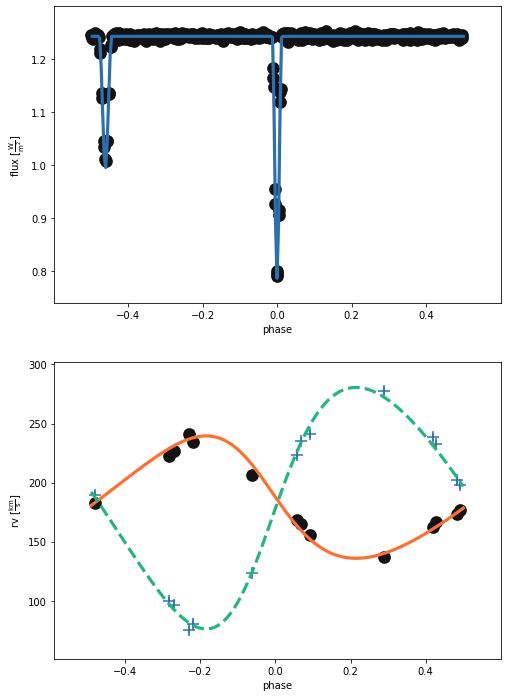

In [37]:
_ = b.plot(model='latest', x='phases', show=True)

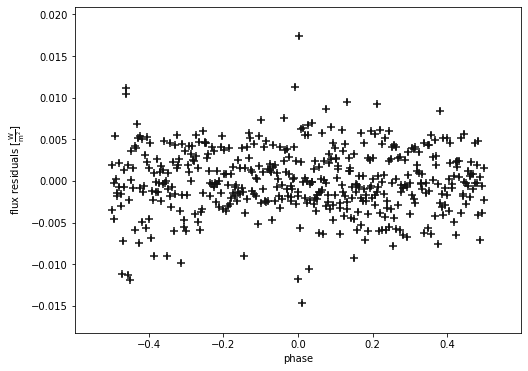

In [38]:
_ = b.plot(model='latest', kind='lc', x='phases', y='residuals', show=True)

In [43]:
# continue the loop above from load_progress to here until happy (~600 iters), then kill
b.kill_job()

# crimpl: ssh terra "scancel 1646"


<ParameterSet: EMPTY>

In [44]:
b.save('after_optimize.bundle')

'after_optimize.bundle'